3 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


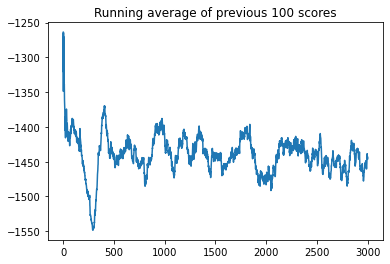

In [ ]:
CUDA_LAUNCH_BLOCKING=1
import torch as t
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
from torch.distributions import Categorical
import numpy as np
from torch.distributions.normal import Normal


device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
###################################################
# Actor Critic model with continus actions
# Criric is for state value
###################################################

class Critic(nn.Module):
    ################################
    #This is a state value function
    ################################
    def __init__(self, dim_state ,h1, h2, alpha=1e-4 ):
        super(Critic, self).__init__()
        
        self.dim_state = dim_state
        self.dim_action = dim_action
        
        self.linear1 = nn.Linear(dim_state, h1)
        self.linear2 = nn.Linear(h1, h2)
        self.linear3 = nn.Linear(h2,1)
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha, weight_decay=1e-4)
        self.device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, state):
        output = state.to(self.device)
        output = F.relu(self.linear1(output))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)
        
        return output
    
class Qvalue(nn.Module):
    #####################
    #This is action value
    #####################
    def __init__(self, dim_state, dim_action, h1, alpha=1e-4):
        super(Qvalue, self).__init__()
        self.linear1 = nn.Linear(dim_state+dim_action, h1)
        self.linear2 = nn.Linear(h1, round(h1/2.0))
        self.linear3 = nn.Linear(round(h1/2.0), 1)
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha, weight_decay=1e-4)
        self.device = t.device('cpu' if t.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, state, action):
        state = state.to(self.device)
        action = action.to(self.device)
        
        output = self.linear1(t.cat((state.view(1,-1), action.view(1,-1)), dim=1))
        output = self.linear2(output)
        output = self.linear3(output)
        
        return output
    
class Actor(nn.Module):
    ###########################################################################
    # This is a generic actor function that outouts two arrays which can be used for 
    # Gaussian based continus actor(Mu,Sigma) for continues actions spaces
    ###########################################################################
    
    def __init__(self, dim_state, dim_action, h1, h2, alpha=0.99, checkpoint='actorGausi.pt'):
        super(Actor, self).__init__()
        self.alpha = alpha
        self.checkpoint = checkpoint
        
        self.dim_state = dim_state
        self.dim_action = dim_action
        
        self.linear1 = nn.Linear(dim_state, h1)
        self.linear2 = nn.Linear(h1, h2)
        
        self.linear_mu = nn.Linear(h2,dim_action) #means
        self.linear_sigma = nn.Linear(h2,dim_action) #stds

        self.optimizer = optim.Adam(self.parameters(), lr = alpha, weight_decay=1e-4)
        self.to(device)
        self.repara = 1e-6
        self.maxm = 10

    def saveChk(self):
        print('save model...')
        t.save(self.state_dict(), self.checkpoint)

    def loadChk(self):
        print('load model')
        self.load_state_dict(t.load(self.checkpoint))

    def forward(self, state):
        output = state.to(device)
        output = F.relu(self.linear1(output))
        output = F.relu(self.linear2(output))

        mu = self.linear_mu(output) #All thg mus
        sigma = self.linear_sigma(output) #All the sigmas

        sigma = t.clamp(sigma, min=self.repara, max=self.maxm)
        return mu, sigma

    def sample(self,state):
        mu, sigma = self.forward(state)
        nm = Normal(mu, sigma)
        action = nm.sample()

        log_probs = nm.log_prob(action)

        return action, log_probs
        
class Agent():
    def __init__(self, env, dim_state, dim_action, alpha, fc1, fc2, maxm_Iters=50, gamma=0.99):
        self.dim_state = dim_state
        self.dim_action = dim_action
        self.gamma = gamma
        self.maxm_Iters = maxm_Iters
        
        self.device = t.device('cpu' if t.cuda.is_available() else 'cpu')
        self.critic = Critic(dim_state,fc1, fc2)
        self.actor = Actor(dim_state, dim_action, fc1,fc2) #dim_state, dim_action, h1, h2
        self.qvalue = Qvalue(dim_state, dim_action, fc1)  #(self, dim_state, dim_action, h1, alpha=1e-4):
        
    def plot_learning_curve(self, x, scores, figure_file='test'):
        running_avg = np.zeros(len(scores))
        for i in range(len(running_avg)):
            running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
        plt.plot(x, running_avg)
        plt.title('Running average of previous 100 scores')
    
    
    def train(self):
      
        reward_list = []
        for i in range(self.maxm_Iters):
            self.critic.train()
            self.actor.train()
        
            state = env.reset()
            total_reward = 0
            done= False
            
            while not done:
                self.critic.zero_grad()
                self.actor.zero_grad()
              
                action,log_probs = self.actor.sample(t.tensor(state).float().to(self.device))
                
                state_next, reward, done, _ = env.step(action.detach().numpy())
                total_reward +=reward
                
                q = self.qvalue(t.tensor(state), t.tensor(action))
                state_value = self.critic(t.tensor(state).float())
                with t.no_grad():
                    target = torch.tensor(reward) + self.gamma * self.critic(t.tensor(state_next).float())*(1-int(done))
                
                advantage = q - state_value
         
                ## Loss for critic
                loss_critic = ((q-target)**2).mean()
                
                ## Loss for actor
                loss_actor = -log_probs * advantage
                
                (loss_critic + loss_actor).backward()
                
                self.actor.optimizer.step()
                self.critic.optimizer.step()
                
                state = state_next
            reward_list.append(total_reward)
            
        x = [i+1 for i in range(self.maxm_Iters)]
        self.plot_learning_curve(x, reward_list)
        
if __name__ == '__main__':
    env = gym.make('Pendulum-v1')
    #env = gym.make('MountainCar-v0')
    dim_state = env.observation_space.shape[0]
    dim_action = env.action_space.shape[0]
    print (dim_state,dim_action )
    
    agent = Agent(env,dim_state,dim_action, 1e-4, 3, 2, maxm_Iters=3000)
    agent.train()
                
#env, dim_state, dim_action, alpha, fc1, fc2,maxm_Iters=50, gamma=0.99):              
              

In [ ]:
env = gym.make('MountainCar-v0')
#env = gym.make('Pendulum-v1')

In [18]:
env.observation_space.sample()

array([-0.24199723,  0.00322727], dtype=float32)

In [19]:
env.action_space

Discrete(3)